# labels layer tutorial

Welcome to the tutorial on the **napari** `Labels` layer!

This tutorial assumes you have already installed **napari**, know how to launch
the viewer, and are familiar with its layout. For help with installation see our
[installation](./installation) tutorial. For help getting started with the
viewer see our [getting started](./getting_started) tutorial. For help
understanding the organisation of the viewer, including things like the layers
list, the layer properties widgets, the layer control panels, and the dimension
sliders see our [napari viewer](./viewer) tutorial.

This tutorial will teach you about the **napari** `Labels` layer, including
using the layer to display the results of image segmentation analyses, and how
to manually segment images using the paintbrush and fill buckets. At the end of
the tutorial you should understand how to add a labels image and edit it from
the GUI and from the console.

The labels layer allows you to take an array of integers and display each
integer as a different random color, with the background color 0 rendered as
transparent.

The `Labels` layer is therefore especially useful for segmentation tasks where
each pixel is assigned to a different class, as occurs in semantic segmentation,
or where pixels corresponding to different objects all get assigned the same
label, as occurs in instance segmentation.

## a simple example

You can create a new viewer and add an labels image in one go using the
`napari.view_labels` method, or if you already have an existing viewer, you can
add a `Labels` image to it using `viewer.add_labels`. The api of both methods is
the same. In these examples we'll mainly use `add_labels` to overlay a `Labels`
image onto on image.

In this example of instance segmentation, we will find and segment each of the
coins in an image, assigning each one an integer label, and then overlay the
results on the original image as follows:

In [1]:
import napari
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects

coins = data.coins()[50:-50, 50:-50]
# apply threshold
thresh = threshold_otsu(coins)
bw = closing(coins > thresh, square(4))
# remove artifacts connected to image border
cleared = remove_small_objects(clear_border(bw), 20)
# label image regions
label_image = label(cleared)

# create the viewer and add the coins image
viewer = napari.view_image(coins, name='coins')
# add the labels
labels_layer = viewer.add_labels(label_image, name='segmentation')

/opt/hostedtoolcache/Python/3.8.11/x64/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


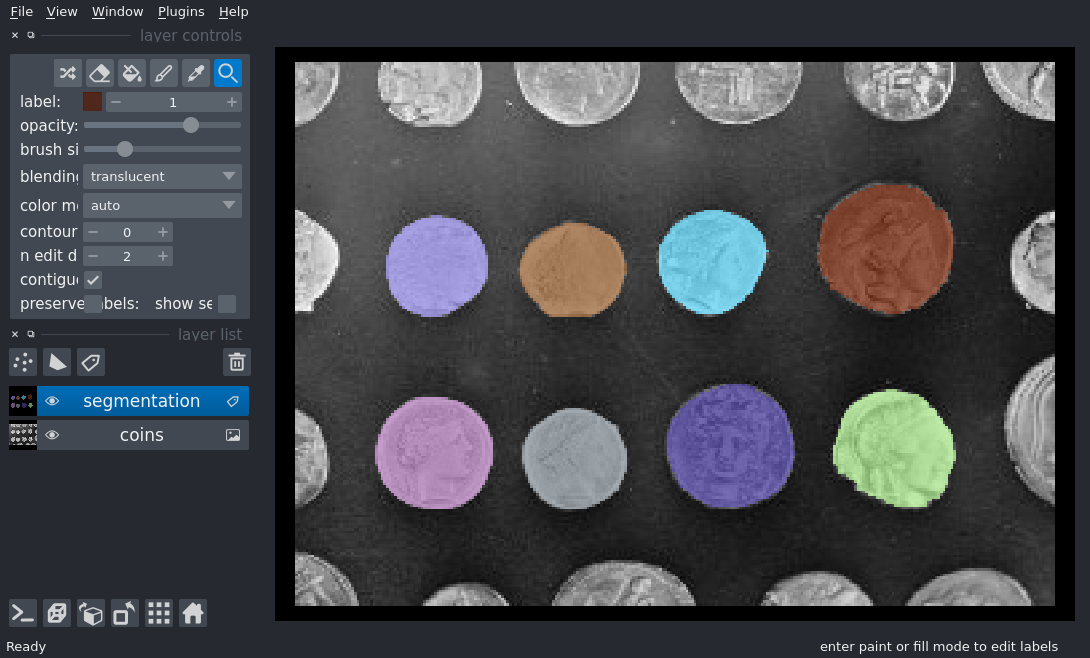

In [2]:
from napari.utils import nbscreenshot

nbscreenshot(viewer)

In [3]:
viewer.close()

## arguments of view_labels and add_labels

{meth}`~napari.view_layers.view_labels` and {meth}`~napari.Viewer.add_labels`
accept the same layer-creation parameters.

In [4]:
help(napari.view_labels)

Help on function view_labels in module napari.view_layers:

view_labels(data, *, num_colors=50, properties=None, color=None, seed=0.5, name=None, metadata=None, scale=None, translate=None, rotate=None, shear=None, affine=None, opacity=0.7, blending='translucent', visible=True, multiscale=None, title='napari', ndisplay=2, order=(), axis_labels=(), show=True) -> napari.viewer.Viewer
    Create a viewer and add a labels layer.
    
    Parameters
    ----------
    data : array or list of array
        Labels data as an array or multiscale. Must be integer type or bools.
        Please note multiscale rendering is only supported in 2D. In 3D, only
        the lowest resolution scale is displayed.
    num_colors : int
        Number of unique colors to use in colormap.
    properties : dict {str: array (N,)} or DataFrame
        Properties for each label. Each property should be an array of length
        N, where N is the number of labels, and the first property corresponds
        to bac

## labels data

The labels layer is a subclass of the `Image` layer and as such can support the
same numpy-like arrays, including [dask
arrays](https://docs.dask.org/en/stable/array.html),
[xarrays](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html),
and [zarr arrays](https://zarr.readthedocs.io/en/stable/api/core.html). A
`Labels` layer though must be integer valued, and the background label must be
0.

Because the labels layer subclasses the image layer it inherits the great
properties of the image layer, like supporting lazy loading and image pyramids
for big data layers. For more information about both these concepts see the
details in the [image layer](./image) tutorial.

## creating a new labels layer

As you can edit a `Labels` layer using the paintbrush and fill bucket, it is
possible to create a brand-new empty labels layers by clicking the new labels
layer button above the layers list. The shape of the new labels layer will match
the size of any currently existing image layers, allowing you to paint on top of
them.

## non-editable mode

If you want to disable editing of the labels layer you can set the `editable`
property of the layer to `False`.

As note in the section on 3D rendering, when using 3D rendering the labels layer
is not editable. Similarly, for now, a labels layer where the data is
represented as an image pyramid is not editable.

## 3D rendering of labels

All our layers can be rendered in both 2D and 3D mode, and one of our viewer
buttons can toggle between each mode. The number of dimensions sliders will be 2
or 3 less than the total number of dimensions of the layer, allowing you to
browse volumetric timeseries data and other high dimensional data.

In [5]:
from scipy import ndimage as ndi

blobs = data.binary_blobs(length=128, volume_fraction=0.1, n_dim=3)
viewer = napari.view_image(blobs.astype(float), name='blobs')
labeled = ndi.label(blobs)[0]
labels_layer = viewer.add_labels(labeled, name='blob ID')
viewer.dims.ndisplay = 3

/opt/hostedtoolcache/Python/3.8.11/x64/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


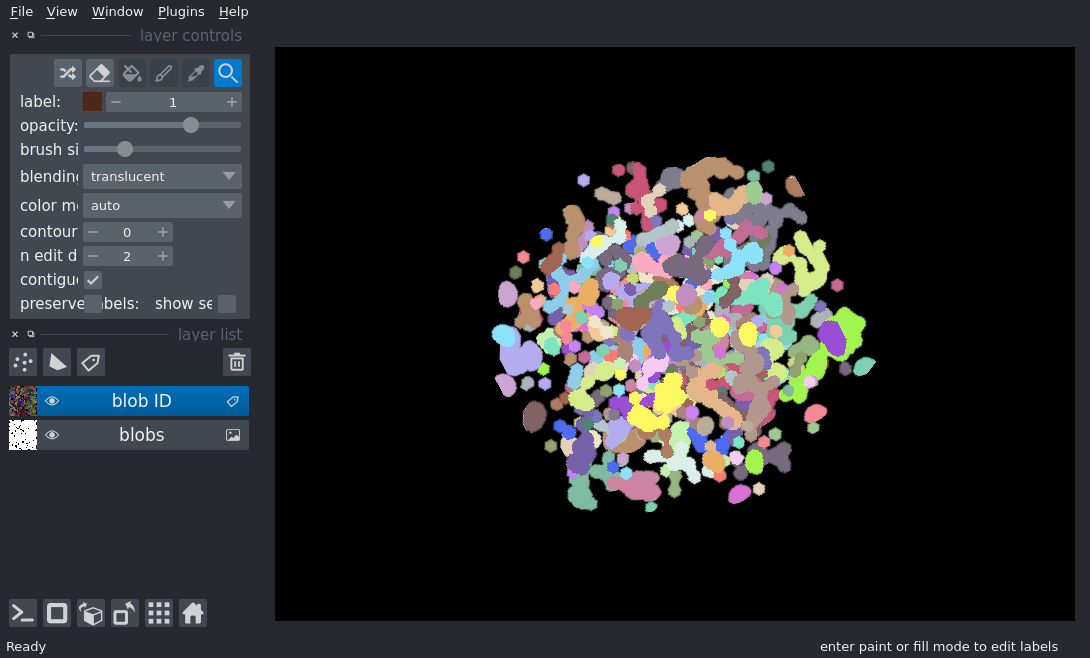

In [6]:
# programmatically adjust the camera angle
viewer.camera.zoom = 2
viewer.camera.angles = (3, 38, 53)
nbscreenshot(viewer)

Note though that when entering 3D rendering mode the colorpicker, paintbrush,
and fill bucket options which allow for layer editing are all disabled. Those
options are only supported when viewing a layer using 2D rendering.

## pan and zoom mode

The default mode of the labels layer is to support panning and zooming, as in
the image layer. This mode is represented by the magnifying glass in the layers
control panel, and while it is selected editing the layer is not possible.
Continue reading to learn how to use some of the editing modes. You can always
return to pan and zoom mode by pressing the `Z` key when the labels layer is
selected.

## shuffling label colors

The color that each integer gets assigned is random, aside from 0 which always
gets assigned to be transparent. The colormap we use is designed such that
nearby integers get assigned distinct colors. The exact colors that get assigned
as determined by a [random
seed](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.seed.html)
and changing that seed will shuffle the colors that each label gets assigned.
Changing the seed can be done by clicking on the `shuffle colors` button in the
layers control panel. Shuffling colors can be useful as some colors may be hard
to distinguish from the background or nearby objects.

## selecting a label

A particular label can be selected either using the label combobox inside the
layers control panel and typing in the value of the desired label or using the
plus / minus buttons, or by selecting the color picker tool and then clicking on
a pixel with the desired label in the image. When a label is selected you will
see its integer inside the label combobox and the color or the label shown in
the thumbnail next to the label combobox. If the 0 label is selected, then a
checkerboard pattern is shown in the thumbnail to represent the transparent
color.

You can quickly select the color picker by pressing the `L` key when the labels
layer is selected.

You can set the selected label to be 0, the background label, by pressing `E`.

You can set the selected label to be one larger than the current largest label
by pressing `M`. This selection will guarantee that you are then using a label
that hasn't been used before.

You can also increment or decrement the currently selected label by pressing the
`I` or `D` key, respectively.

## painting in the labels layer

One of the major use cases for the labels layer is to manually edit or create
image segmentations. One of the tools that can be used for manual editing is the
`paintbrush`, that can be made active from by clicking the paintbrush icon in
the layers control panel. Once the paintbrush is enabled, the pan and zoom
functionality of the  viewer canvas gets disabled, and you can paint onto the
canvas. You can temporarily re-enable pan and zoom by pressing and holding the
spacebar. This feature can be useful if you want to move around the labels layer
as you paint.

When you start painting the label that you are painting with, and the color that
you will see are determined by the selected label. Note there is no explicit
eraser tool, instead you just need to make the selected label 0 and then you are
effectively painting with the background color. Remember you can use the color
picker tool at any point to change the selected label.

You can adjust the size of your paintbrush using the brush size slider, making
it as small as a single pixel for incredibly detailed painting.

If you have a multidimensional labels layer then your paintbrush will only edit
data in the visible slice by default; however, if you enable the `n_dimensional`
property and paintbrush then your paintbrush will extend out into neighbouring
slices according to its size.

You can quickly select the paintbrush by pressing the `P` key when the labels
layer is selected.

## using the fill bucket

Sometimes you might want to replace an entire label with a different label. This
could be because you want to make two touching regions have the same label, or
you want to just replace one label with a different one, or maybe you have
painted around the edge of a region and you want to quickly fill in its inside.
To do this you can select the `fill bucket` by clicking on the droplet icon in
the layer controls panel and then click on a target region of interest in the
layer. The fill bucket will fill using the currently selected label.

By default, the fill bucket will only change contiguous or connected pixels of
the same label as the pixel that is clicked on. If you want to change all the
pixels of that label regardless of where they are in the slice, then you can set
the `contiguous` property or checkbox to `False`.

If you have a multidimensional labels layer then your fill bucket will only edit
data in the visible slice by default; however, if you enable the `n_dimensional`
property and paintbrush then your fill bucket will extend out into neighbouring
slices, either to all pixels with that label in the layer, or only connected
pixels depending on if the contiguous property is disabled or not.

You can quickly select the fill bucket by pressing the `F` key when the labels
layer is selected.

## creating, deleting, merging, and splitting connected components

Using the `color picker`, `paintbrush`, and `fill bucket` tools one can create
and edit object segmentation maps. Below we show how to use these tools to by
perform common editing tasks on connected components (keep the `contiguous` box
checked).

**drawing a connected component**:

![image: draw component](../assets/tutorials/draw_component.gif)

Press `M` to select a new label color. Select the `paintbrush` tool and draw a
closed contour around the object. Select the `fill bucket` tool and click inside
the contour to assign the label to all pixels of the object.

**selecting a connected component**:

![image: delete label](../assets/tutorials/delete_label.gif)

select the background label with the `color picker` (alternative: press keyboard
shortcut `E`), then use the `fill bucket` to set all pixels of the connected
component to background.

**merging connected components**:

![image: merge labels](../assets/tutorials/merge_labels.gif)

select the label of one of the components with the `color picker` tool and then
filling the components to be merged with the fill bucket.

**splitting a connected component**:

![image: split label](../assets/tutorials/split_label.gif)

splitting a connected component will introduce an additional object, therefore
press `M` to select a label number that is not already in use. Use the
paintbrush tool to draw a dividing line, then assign the new label to one of the
parts with the `fill bucket`.

## undo / redo functionality

When painting or using the fill bucket it can be easy to make a mistake that you
might want to undo or then redo. For the labels layer we support an undo with
`ctrl-Z` and redo with `shift-ctrl-Z`. We plan to support this sort of
functionality more generally, but for now these actions will undo the most
recent painting or filling event, up to 100 events in the past.

If you have multidimensional data, then adjusting the currently viewed slice
will cause the undo history to be reset.

## layer visibility

All our layers support a visibility toggle that allows you to set the `visible`
property of each layer. This property is located inside the layer widget in the
layers list and is represented by an eye icon.

## layer opacity

All our layers support an opacity slider and `opacity` property that allow you
to adjust the layer opacity between 0, fully invisible, and 1, fully visible.

## blending layers

All our layers support three blending modes `translucent`, `additive`, and
`opaque` that determine how the visuals for this layer get mixed with the
visuals from the other layers.

An `opaque` layer renders all the other layers below it invisible and will fade
to black as you decrease its opacity.

The `translucent` setting will cause the layer to blend with the layers below it
if you decrease its opacity but will fully block those layers if its opacity is
1. This is a reasonable default, useful for many applications.

The final blending mode `additive` will cause the layer to blend with the layers
below even when it has full opacity. This mode is especially useful for
visualizing multiple layers at the same time.

## naming layers

All our layers support a `name` property that can be set inside a text box
inside the layer widget in the layers list. The name of each layer is forced
into being unique so that you can use the name to index into `viewer.layers` to
retrieve the layer object.

## scaling layers

All our layers support a `scale` property and keyword argument that will rescale
the layer multiplicatively according to the scale values (one for each
dimension). This property can be particularly useful for viewing anisotropic
volumes where the size of the voxel in the z dimension might be different then
the size in the x and y dimensions.

## translating layers

All our layers support a `translate` property and keyword argument that you can
use to offset a layer relative to the other layers, which could be useful if you
are trying to overlay two layers for image registration purposes.

## layer metadata

All our layers also support a `metadata` property and keyword argument that you
can use to store an arbitrary metadata dictionary on the layer.

## next steps

Hopefully, this tutorial has given you a detailed understanding of the `Labels`
layer, including how to create one and control its properties. To learn more
about some of the other layer types that **napari** supports checkout some more
of our tutorials listed below. The [points layer](./points) tutorial is a great
one to try next as points are one of our simplest shape-like layers.